In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.decomposition import PCA, TruncatedSVD, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
import itertools
import pickle
import logging

In [2]:
df = pd.read_csv("../data/run-over-dataset.csv")
print(df.shape)

columns_to_drop = ['VERBALE', 'DATA', 'Tot Testa', 'Tot Torace', 'Tot Addome', 'Tot Scheletro',
                    'Totale', 'Tot Volta cranica', 'Tot Base cranica', 
                    'Tot Neuroc.', 'Tot Splancnoc.', 'Tot Testa',
                    'Tot Tratto toracico', 'Tot Tratto lombare', 'Tot Rachide',
                    ' Totale coste', 'Sterno in toto', 'Tot Bacino', 'I costa dx', 'II costa dx',
                    'III costa dx', 'IV costa dx', 'V costa dx', 'VI costa dx', 'VII costa dx', 
                    'VIII costa dx', 'IX costa dx', 'X costa dx', 'XI costa dx', 'XII costa dx',
                    'I costa sx', 'II costa sx', 'III costa sx', 'IV costa sx', 'V costa sx', 
                    'VI costa sx', 'VII costa sx', 'VIII costa sx', 'IX costa sx', 
                    'X costa sx', 'XI costa sx', 'XII costa sx']

X = df.drop(columns=columns_to_drop)
print(X.shape)

X['ALTEZZA'] = [int(float(h.replace(',', '.'))*100) for h in X['ALTEZZA']]
X['PESO'] = [int(float(str(h).replace(',', '.'))) for h in X['PESO']]
X['BMI'] = [float(str(h).replace(',', '.')) for h in X['BMI']]

num_unique_values = X.nunique()
constant_columns = num_unique_values[num_unique_values == 1].index.tolist()

X = X.drop(columns=constant_columns)
X = X.T.drop_duplicates().T
print(X.shape)

(130, 367)
(130, 326)
(130, 274)


In [3]:
random_seed = 3355825

In [4]:
def add_record(df, record):
    new_record = pd.DataFrame(record, index=[0])
    df = pd.concat([df, new_record], ignore_index=True)
    return df  

In [5]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

file_handler = logging.FileHandler('../logs/if_nested_cv.log')
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))

logger = logging.getLogger()

logger.handlers = []
logger.addHandler(file_handler)

In [6]:
def nested_cv(X, random_seed, decomposition, n_outer_folds=7, n_inner_folds=5, n_components=60, mod_selection_score=accuracy_score, positive_class=0):
    n_estimatorss = np.arange(50, 151, 50)
    contaminations = np.linspace(0.01, 0.5, 5)
    max_featuress = np.linspace(0.1, 1.0, 5)
    scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]
    
    best_params = {'n_estimators': 0, 'contamination': 0, 'max_features': 0, 'pca': 0, 'scaler': ''}
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    best_overall_accuracy = 0
    best_overall_params = {'n_estimators': 0, 'contamination': 0, 'max_features': 0, 'pca': 0, 'scaler': ''}

    y = X['Mezzo'].values
    y = np.array([0. if x == positive_class else 1. for x in y], dtype=float)
    
    X = X.drop(columns='Mezzo').values

    outer_cv = StratifiedKFold(n_splits=n_outer_folds, shuffle=True, random_state=random_seed)
        
    for outer_cv_number, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        inner_cv = StratifiedKFold(n_splits=n_inner_folds, shuffle=True, random_state=random_seed)

        best_score = 0
        best_decomp = decomposition
        best_scaler = StandardScaler()
        for inner_cv_number, (trainval_idx, valid_idx) in enumerate(inner_cv.split(X_train, y_train)):
            for params in itertools.product(n_estimatorss, contaminations, max_featuress, scalers):
                scaler = params[3]
                X_trainval, X_valid = X_train[trainval_idx], X_train[valid_idx]
                y_trainval, y_valid = y_train[trainval_idx], y_train[valid_idx]

                X_trainval_scaled = scaler.fit_transform(X_trainval)
                X_valid_scaled = scaler.transform(X_valid)
                
                decomp = decomposition(n_components=n_components)
                X_trainval_reduced = decomp.fit_transform(X_trainval_scaled)
                X_valid_reduced = decomp.transform(X_valid_scaled)

                idxs_neg = np.where(y_trainval == 1)[0]
                X_trainval_reduced = np.delete(X_trainval_reduced, idxs_neg, axis=0)
                y_trainval = np.delete(y_trainval, idxs_neg)

                clf = IsolationForest(n_estimators=params[0], contamination=params[1], max_features=params[2])
                    
                clf.fit(X_trainval_reduced)
                    
                pred_values = clf.predict(X_valid_reduced)
                true_values = [1 if y == 0 else -1 for y in y_valid]
                    
                score = mod_selection_score(true_values, pred_values)
                curr_params = {
                        'n_estimators': params[0],
                        'contamination': params[1],
                        'max_features': params[2],
                        'components': n_components,
                        'scaler': params[3]
                }

                logging.info(f"inner cv number: {inner_cv_number}, {mod_selection_score.__name__}: {score}, with params: {curr_params}")
                        
                if score > best_score:
                    best_score = score
                    best_decomposition = decomp
                    best_scaler = scaler
                    best_params = curr_params

        idxs_neg = np.where(y_train == 1)[0]
        X_train = np.delete(X_train, idxs_neg, axis=0)
        y_train = np.delete(y_train, idxs_neg)

        X_train_scaled = best_scaler.fit_transform(X_train)
        X_test_scaled = best_scaler.transform(X_test)

        X_train_reduced = best_decomposition.transform(X_train_scaled)
        X_test_reduced = best_decomposition.transform(X_test_scaled)

        clf = IsolationForest(n_estimators=best_params['n_estimators'], contamination=best_params['contamination'], max_features=best_params['max_features'])
        clf.fit(X_train_reduced)

        pred_values = clf.predict(X_test_reduced)
        true_values = [1 if y == 0 else -1 for y in y_test]

        accuracy = accuracy_score(true_values, pred_values)
        precision = precision_score(true_values, pred_values, zero_division=0.0)
        recall = recall_score(true_values, pred_values, zero_division=0.0)
        f1 = f1_score(true_values, pred_values, zero_division=0.0)

        if accuracy > best_overall_accuracy:
            best_overall_accuracy = accuracy
            best_overall_params = best_params

        logging.info(f"outer cv number: {outer_cv_number}, accuracy: {accuracy}, precision: {precision}, recall: {recall}, f1: {f1} with params: {best_params}")

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    return {
        'algorythm': 'IsolationForest',
        'best n_estimators': best_overall_params['n_estimators'],
        'best contamination': best_overall_params['contamination'],
        'best max_features': best_overall_params['max_features'],
        'decomposition': decomposition,
        'n_components': best_overall_params['components'],
        'best scaler': best_overall_params['scaler'],
        'score used for model selection': mod_selection_score.__name__,
        'method used for model selection': 'nested cv',
        'accuracy mean': np.mean(accuracy_scores) * 100,
        'accuracy std': np.std(accuracy_scores) * 100,
        'precision mean': np.mean(precision_scores) * 100,
        'precision std': np.std(precision_scores) * 100,
        'recall mean': np.mean(recall_scores) * 100,
        'recall std': np.std(recall_scores) * 100,
        'f1 mean': np.mean(f1_scores) * 100,
        'f1 std': np.std(f1_scores) * 100,
        'best overall accuracy': best_overall_accuracy * 100,
        'class': positive_class
    }

In [7]:
results = nested_cv(X, random_seed, PCA, n_components=85, mod_selection_score=accuracy_score, positive_class=0)
scores_df = pd.DataFrame(results, index=[0])
scores_df

,algorythm,best n_estimators,best contamination,best max_features,decomposition,n_components,best scaler,score used for model selection,method used for model selection,accuracy mean,accuracy std,precision mean,precision std,recall mean,recall std,f1 mean,f1 std,best overall accuracy,class
0,IsolationForest,100,0.1325,0.55,<class 'sklearn.decomposition._pca.PCA'>,85,StandardScaler(),accuracy_score,nested cv,68.71345,11.809184,67.615995,8.970701,81.428571,22.314999,72.475482,12.812223,88.888889,0


In [8]:
for pca_comps in np.arange(80, 49, -5):
    scores_df = add_record(scores_df, nested_cv(X, random_seed, PCA, n_components=pca_comps, mod_selection_score=accuracy_score, positive_class=0))

scores_df

,algorythm,best n_estimators,best contamination,best max_features,decomposition,n_components,best scaler,score used for model selection,method used for model selection,accuracy mean,accuracy std,precision mean,precision std,recall mean,recall std,f1 mean,f1 std,best overall accuracy,class
0,IsolationForest,100,0.1325,0.550,<class 'sklearn.decomposition._pca.PCA'>,85,StandardScaler(),accuracy_score,nested cv,68.713450,11.809184,67.615995,8.970701,81.428571,22.314999,72.475482,12.812223,88.888889,0
1,IsolationForest,100,0.1325,1.000,<class 'sklearn.decomposition._pca.PCA'>,80,RobustScaler(),accuracy_score,nested cv,62.489557,12.822433,63.238526,11.861377,71.428571,20.995626,65.995350,14.963328,83.333333,0
2,IsolationForest,50,0.3775,0.775,<class 'sklearn.decomposition._pca.PCA'>,75,StandardScaler(),accuracy_score,nested cv,67.084378,10.876538,69.015152,10.127500,70.000000,13.093073,69.253437,11.100972,88.888889,0
3,IsolationForest,50,0.2550,0.775,<class 'sklearn.decomposition._pca.PCA'>,70,RobustScaler(),accuracy_score,nested cv,65.413534,9.273747,66.038723,7.356919,72.857143,17.496355,68.476877,11.201495,78.947368,0
4,IsolationForest,100,0.5000,1.000,<class 'sklearn.decomposition._pca.PCA'>,65,RobustScaler(),accuracy_score,nested cv,61.654135,9.406754,68.934240,8.583163,51.428571,20.303815,57.000178,15.272524,77.777778,0
5,IsolationForest,50,0.5000,1.000,<class 'sklearn.decomposition._pca.PCA'>,60,RobustScaler(),accuracy_score,nested cv,64.745196,11.054750,69.890110,12.323075,60.000000,20.000000,63.203934,14.871353,77.777778,0
6,IsolationForest,100,0.5000,0.325,<class 'sklearn.decomposition._pca.PCA'>,55,RobustScaler(),accuracy_score,nested cv,67.836257,13.904819,70.674088,11.229100,68.571429,26.418917,67.297828,17.196719,94.444444,0
7,IsolationForest,50,0.5000,0.325,<class 'sklearn.decomposition._pca.PCA'>,50,RobustScaler(),accuracy_score,nested cv,65.455305,8.306253,67.380952,5.463235,68.571429,22.946255,66.324144,12.360738,77.777778,0


In [9]:
for pca_comps in np.arange(85, 49, -5):
    scores_df = add_record(scores_df, nested_cv(X, random_seed, PCA, n_components=pca_comps, mod_selection_score=f1_score, positive_class=0))

scores_df

,algorythm,best n_estimators,best contamination,best max_features,decomposition,n_components,best scaler,score used for model selection,method used for model selection,accuracy mean,accuracy std,precision mean,precision std,recall mean,recall std,f1 mean,f1 std,best overall accuracy,class
0,IsolationForest,100,0.1325,0.550,<class 'sklearn.decomposition._pca.PCA'>,85,StandardScaler(),accuracy_score,nested cv,68.713450,11.809184,67.615995,8.970701,81.428571,22.314999,72.475482,12.812223,88.888889,0
1,IsolationForest,100,0.1325,1.000,<class 'sklearn.decomposition._pca.PCA'>,80,RobustScaler(),accuracy_score,nested cv,62.489557,12.822433,63.238526,11.861377,71.428571,20.995626,65.995350,14.963328,83.333333,0
2,IsolationForest,50,0.3775,0.775,<class 'sklearn.decomposition._pca.PCA'>,75,StandardScaler(),accuracy_score,nested cv,67.084378,10.876538,69.015152,10.127500,70.000000,13.093073,69.253437,11.100972,88.888889,0
3,IsolationForest,50,0.2550,0.775,<class 'sklearn.decomposition._pca.PCA'>,70,RobustScaler(),accuracy_score,nested cv,65.413534,9.273747,66.038723,7.356919,72.857143,17.496355,68.476877,11.201495,78.947368,0
4,IsolationForest,100,0.5000,1.000,<class 'sklearn.decomposition._pca.PCA'>,65,RobustScaler(),accuracy_score,nested cv,61.654135,9.406754,68.934240,8.583163,51.428571,20.303815,57.000178,15.272524,77.777778,0
5,IsolationForest,50,0.5000,1.000,<class 'sklearn.decomposition._pca.PCA'>,60,RobustScaler(),accuracy_score,nested cv,64.745196,11.054750,69.890110,12.323075,60.000000,20.000000,63.203934,14.871353,77.777778,0
6,IsolationForest,100,0.5000,0.325,<class 'sklearn.decomposition._pca.PCA'>,55,RobustScaler(),accuracy_score,nested cv,67.836257,13.904819,70.674088,11.229100,68.571429,26.418917,67.297828,17.196719,94.444444,0
7,IsolationForest,50,0.5000,0.325,<class 'sklearn.decomposition._pca.PCA'>,50,RobustScaler(),accuracy_score,nested cv,65.455305,8.306253,67.380952,5.463235,68.571429,22.946255,66.324144,12.360738,77.777778,0
8,IsolationForest,50,0.1325,0.325,<class 'sklearn.decomposition._pca.PCA'>,85,MinMaxScaler(),f1_score,nested cv,64.703425,7.091497,65.496805,8.148966,75.714286,14.982984,69.280702,8.046850,77.777778,0
9,IsolationForest,50,0.1325,0.100,<class 'sklearn.decomposition._pca.PCA'>,80,MinMaxScaler(),f1_score,nested cv,66.332498,12.726550,70.772561,10.579093,64.285714,21.946131,65.673752,14.631377,83.333333,0


In [10]:
file_path = '../pickles/if_df.pickle'

with open(file_path, "wb") as file:
    pickle.dump(scores_df, file)

In [11]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

file_handler = logging.FileHandler('../logs/if_svd_nested_cv.log')
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))

logger = logging.getLogger()

logger.handlers = []
logger.addHandler(file_handler)

In [12]:
for n_comps in np.arange(85, 49, -5):
    scores_df = add_record(scores_df, nested_cv(X, random_seed, TruncatedSVD, n_components=n_comps))

scores_df

,algorythm,best n_estimators,best contamination,best max_features,decomposition,n_components,best scaler,score used for model selection,method used for model selection,accuracy mean,accuracy std,precision mean,precision std,recall mean,recall std,f1 mean,f1 std,best overall accuracy,class
0,IsolationForest,100,0.1325,0.550,<class 'sklearn.decomposition._pca.PCA'>,85,StandardScaler(),accuracy_score,nested cv,68.713450,11.809184,67.615995,8.970701,81.428571,22.314999,72.475482,12.812223,88.888889,0
1,IsolationForest,100,0.1325,1.000,<class 'sklearn.decomposition._pca.PCA'>,80,RobustScaler(),accuracy_score,nested cv,62.489557,12.822433,63.238526,11.861377,71.428571,20.995626,65.995350,14.963328,83.333333,0
2,IsolationForest,50,0.3775,0.775,<class 'sklearn.decomposition._pca.PCA'>,75,StandardScaler(),accuracy_score,nested cv,67.084378,10.876538,69.015152,10.127500,70.000000,13.093073,69.253437,11.100972,88.888889,0
3,IsolationForest,50,0.2550,0.775,<class 'sklearn.decomposition._pca.PCA'>,70,RobustScaler(),accuracy_score,nested cv,65.413534,9.273747,66.038723,7.356919,72.857143,17.496355,68.476877,11.201495,78.947368,0
4,IsolationForest,100,0.5000,1.000,<class 'sklearn.decomposition._pca.PCA'>,65,RobustScaler(),accuracy_score,nested cv,61.654135,9.406754,68.934240,8.583163,51.428571,20.303815,57.000178,15.272524,77.777778,0
5,IsolationForest,50,0.5000,1.000,<class 'sklearn.decomposition._pca.PCA'>,60,RobustScaler(),accuracy_score,nested cv,64.745196,11.054750,69.890110,12.323075,60.000000,20.000000,63.203934,14.871353,77.777778,0
6,IsolationForest,100,0.5000,0.325,<class 'sklearn.decomposition._pca.PCA'>,55,RobustScaler(),accuracy_score,nested cv,67.836257,13.904819,70.674088,11.229100,68.571429,26.418917,67.297828,17.196719,94.444444,0
7,IsolationForest,50,0.5000,0.325,<class 'sklearn.decomposition._pca.PCA'>,50,RobustScaler(),accuracy_score,nested cv,65.455305,8.306253,67.380952,5.463235,68.571429,22.946255,66.324144,12.360738,77.777778,0
8,IsolationForest,50,0.1325,0.325,<class 'sklearn.decomposition._pca.PCA'>,85,MinMaxScaler(),f1_score,nested cv,64.703425,7.091497,65.496805,8.148966,75.714286,14.982984,69.280702,8.046850,77.777778,0
9,IsolationForest,50,0.1325,0.100,<class 'sklearn.decomposition._pca.PCA'>,80,MinMaxScaler(),f1_score,nested cv,66.332498,12.726550,70.772561,10.579093,64.285714,21.946131,65.673752,14.631377,83.333333,0


In [13]:
for n_comps in np.arange(85, 49, -5):
    scores_df = add_record(scores_df, nested_cv(X, random_seed, TruncatedSVD, n_components=n_comps, mod_selection_score=f1_score))

scores_df

,algorythm,best n_estimators,best contamination,best max_features,decomposition,n_components,best scaler,score used for model selection,method used for model selection,accuracy mean,accuracy std,precision mean,precision std,recall mean,recall std,f1 mean,f1 std,best overall accuracy,class
0,IsolationForest,100,0.1325,0.550,<class 'sklearn.decomposition._pca.PCA'>,85,StandardScaler(),accuracy_score,nested cv,68.713450,11.809184,67.615995,8.970701,81.428571,22.314999,72.475482,12.812223,88.888889,0
1,IsolationForest,100,0.1325,1.000,<class 'sklearn.decomposition._pca.PCA'>,80,RobustScaler(),accuracy_score,nested cv,62.489557,12.822433,63.238526,11.861377,71.428571,20.995626,65.995350,14.963328,83.333333,0
2,IsolationForest,50,0.3775,0.775,<class 'sklearn.decomposition._pca.PCA'>,75,StandardScaler(),accuracy_score,nested cv,67.084378,10.876538,69.015152,10.127500,70.000000,13.093073,69.253437,11.100972,88.888889,0
3,IsolationForest,50,0.2550,0.775,<class 'sklearn.decomposition._pca.PCA'>,70,RobustScaler(),accuracy_score,nested cv,65.413534,9.273747,66.038723,7.356919,72.857143,17.496355,68.476877,11.201495,78.947368,0
4,IsolationForest,100,0.5000,1.000,<class 'sklearn.decomposition._pca.PCA'>,65,RobustScaler(),accuracy_score,nested cv,61.654135,9.406754,68.934240,8.583163,51.428571,20.303815,57.000178,15.272524,77.777778,0
5,IsolationForest,50,0.5000,1.000,<class 'sklearn.decomposition._pca.PCA'>,60,RobustScaler(),accuracy_score,nested cv,64.745196,11.054750,69.890110,12.323075,60.000000,20.000000,63.203934,14.871353,77.777778,0
6,IsolationForest,100,0.5000,0.325,<class 'sklearn.decomposition._pca.PCA'>,55,RobustScaler(),accuracy_score,nested cv,67.836257,13.904819,70.674088,11.229100,68.571429,26.418917,67.297828,17.196719,94.444444,0
7,IsolationForest,50,0.5000,0.325,<class 'sklearn.decomposition._pca.PCA'>,50,RobustScaler(),accuracy_score,nested cv,65.455305,8.306253,67.380952,5.463235,68.571429,22.946255,66.324144,12.360738,77.777778,0
8,IsolationForest,50,0.1325,0.325,<class 'sklearn.decomposition._pca.PCA'>,85,MinMaxScaler(),f1_score,nested cv,64.703425,7.091497,65.496805,8.148966,75.714286,14.982984,69.280702,8.046850,77.777778,0
9,IsolationForest,50,0.1325,0.100,<class 'sklearn.decomposition._pca.PCA'>,80,MinMaxScaler(),f1_score,nested cv,66.332498,12.726550,70.772561,10.579093,64.285714,21.946131,65.673752,14.631377,83.333333,0


In [15]:
file_path = '../pickles/if_df.pickle'

with open(file_path, "rb") as file:
    scores_df = pickle.load(file)

In [16]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

file_handler = logging.FileHandler('../logs/if_fastica_nested_cv.log')
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))

logger = logging.getLogger()

logger.handlers = []
logger.addHandler(file_handler)

In [17]:
for n_comps in np.arange(85, 49, -5):
    scores_df = add_record(scores_df, nested_cv(X, random_seed, FastICA, n_components=n_comps))

scores_df

,algorythm,best n_estimators,best contamination,best max_features,decomposition,n_components,best scaler,score used for model selection,method used for model selection,accuracy mean,accuracy std,precision mean,precision std,recall mean,recall std,f1 mean,f1 std,best overall accuracy,class
0,IsolationForest,100,0.1325,0.550,<class 'sklearn.decomposition._pca.PCA'>,85,StandardScaler(),accuracy_score,nested cv,68.713450,11.809184,67.615995,8.970701,81.428571,22.314999,72.475482,12.812223,88.888889,0
1,IsolationForest,100,0.1325,1.000,<class 'sklearn.decomposition._pca.PCA'>,80,RobustScaler(),accuracy_score,nested cv,62.489557,12.822433,63.238526,11.861377,71.428571,20.995626,65.995350,14.963328,83.333333,0
2,IsolationForest,50,0.3775,0.775,<class 'sklearn.decomposition._pca.PCA'>,75,StandardScaler(),accuracy_score,nested cv,67.084378,10.876538,69.015152,10.127500,70.000000,13.093073,69.253437,11.100972,88.888889,0
3,IsolationForest,50,0.2550,0.775,<class 'sklearn.decomposition._pca.PCA'>,70,RobustScaler(),accuracy_score,nested cv,65.413534,9.273747,66.038723,7.356919,72.857143,17.496355,68.476877,11.201495,78.947368,0
4,IsolationForest,100,0.5000,1.000,<class 'sklearn.decomposition._pca.PCA'>,65,RobustScaler(),accuracy_score,nested cv,61.654135,9.406754,68.934240,8.583163,51.428571,20.303815,57.000178,15.272524,77.777778,0
5,IsolationForest,50,0.5000,1.000,<class 'sklearn.decomposition._pca.PCA'>,60,RobustScaler(),accuracy_score,nested cv,64.745196,11.054750,69.890110,12.323075,60.000000,20.000000,63.203934,14.871353,77.777778,0
6,IsolationForest,100,0.5000,0.325,<class 'sklearn.decomposition._pca.PCA'>,55,RobustScaler(),accuracy_score,nested cv,67.836257,13.904819,70.674088,11.229100,68.571429,26.418917,67.297828,17.196719,94.444444,0
7,IsolationForest,50,0.5000,0.325,<class 'sklearn.decomposition._pca.PCA'>,50,RobustScaler(),accuracy_score,nested cv,65.455305,8.306253,67.380952,5.463235,68.571429,22.946255,66.324144,12.360738,77.777778,0
8,IsolationForest,50,0.1325,0.325,<class 'sklearn.decomposition._pca.PCA'>,85,MinMaxScaler(),f1_score,nested cv,64.703425,7.091497,65.496805,8.148966,75.714286,14.982984,69.280702,8.046850,77.777778,0
9,IsolationForest,50,0.1325,0.100,<class 'sklearn.decomposition._pca.PCA'>,80,MinMaxScaler(),f1_score,nested cv,66.332498,12.726550,70.772561,10.579093,64.285714,21.946131,65.673752,14.631377,83.333333,0


In [18]:
for n_comps in np.arange(85,49, -5):
    scores_df = add_record(scores_df, nested_cv(X, random_seed, FastICA, n_components=n_comps, mod_selection_score=f1_score))

scores_df

,algorythm,best n_estimators,best contamination,best max_features,decomposition,n_components,best scaler,score used for model selection,method used for model selection,accuracy mean,accuracy std,precision mean,precision std,recall mean,recall std,f1 mean,f1 std,best overall accuracy,class
0,IsolationForest,100,0.1325,0.550,<class 'sklearn.decomposition._pca.PCA'>,85,StandardScaler(),accuracy_score,nested cv,68.713450,11.809184,67.615995,8.970701,81.428571,22.314999,72.475482,12.812223,88.888889,0
1,IsolationForest,100,0.1325,1.000,<class 'sklearn.decomposition._pca.PCA'>,80,RobustScaler(),accuracy_score,nested cv,62.489557,12.822433,63.238526,11.861377,71.428571,20.995626,65.995350,14.963328,83.333333,0
2,IsolationForest,50,0.3775,0.775,<class 'sklearn.decomposition._pca.PCA'>,75,StandardScaler(),accuracy_score,nested cv,67.084378,10.876538,69.015152,10.127500,70.000000,13.093073,69.253437,11.100972,88.888889,0
3,IsolationForest,50,0.2550,0.775,<class 'sklearn.decomposition._pca.PCA'>,70,RobustScaler(),accuracy_score,nested cv,65.413534,9.273747,66.038723,7.356919,72.857143,17.496355,68.476877,11.201495,78.947368,0
4,IsolationForest,100,0.5000,1.000,<class 'sklearn.decomposition._pca.PCA'>,65,RobustScaler(),accuracy_score,nested cv,61.654135,9.406754,68.934240,8.583163,51.428571,20.303815,57.000178,15.272524,77.777778,0
5,IsolationForest,50,0.5000,1.000,<class 'sklearn.decomposition._pca.PCA'>,60,RobustScaler(),accuracy_score,nested cv,64.745196,11.054750,69.890110,12.323075,60.000000,20.000000,63.203934,14.871353,77.777778,0
6,IsolationForest,100,0.5000,0.325,<class 'sklearn.decomposition._pca.PCA'>,55,RobustScaler(),accuracy_score,nested cv,67.836257,13.904819,70.674088,11.229100,68.571429,26.418917,67.297828,17.196719,94.444444,0
7,IsolationForest,50,0.5000,0.325,<class 'sklearn.decomposition._pca.PCA'>,50,RobustScaler(),accuracy_score,nested cv,65.455305,8.306253,67.380952,5.463235,68.571429,22.946255,66.324144,12.360738,77.777778,0
8,IsolationForest,50,0.1325,0.325,<class 'sklearn.decomposition._pca.PCA'>,85,MinMaxScaler(),f1_score,nested cv,64.703425,7.091497,65.496805,8.148966,75.714286,14.982984,69.280702,8.046850,77.777778,0
9,IsolationForest,50,0.1325,0.100,<class 'sklearn.decomposition._pca.PCA'>,80,MinMaxScaler(),f1_score,nested cv,66.332498,12.726550,70.772561,10.579093,64.285714,21.946131,65.673752,14.631377,83.333333,0


In [19]:
file_path = '../pickles/if_df.pickle'

with open(file_path, "wb") as file:
    pickle.dump(scores_df, file)

In [21]:
def plot_components(X):
    components = []
    variance = []

    for pca_comps in np.arange(1, 101, 1):
        pca = PCA(n_components=pca_comps)
        X_temp = X.drop(columns='Mezzo').values
        pca.fit_transform(X_temp)

        components.append(pca_comps)
        variance.append(np.sum(pca.explained_variance_ratio_))
    
    plt.figure(figsize=(10, 6))
    plt.plot(components, variance, marker='o', linestyle='--', color='b')
    plt.title('Varianza totale spiegata dai componenti principali')
    plt.xlabel('Numero di Componenti Principali')
    plt.ylabel('Varianza spiegata cumulativa')
    plt.show()


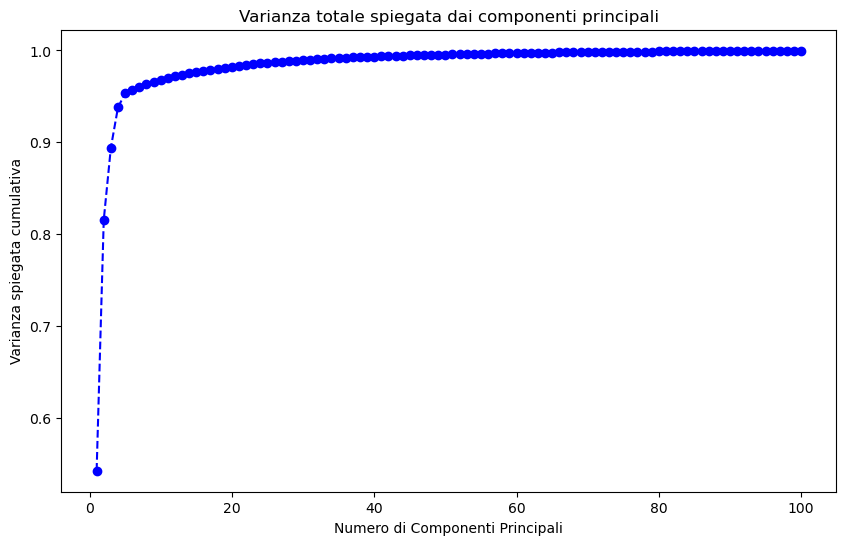

In [22]:
plot_components(X)

In [27]:
def plot_error_bar(df, n_init, n_end, decomposition, score):
    df = df.iloc[n_init:n_end+1]
    n_comps = df['n_components']
    accuracy_mean = df['accuracy mean']
    accuracy_std = df['accuracy std']

    plt.figure(figsize=(10, 6))
    plt.errorbar(n_comps, accuracy_mean, yerr=accuracy_std, fmt='o', linestyle='--', color='b', ecolor='r', capsize=5)
    plt.title('Accuratezza con ' + decomposition + ' usando ' + score + " per la model selection")
    plt.xlabel('Numero di Componenti Principali')
    plt.ylabel('Accuratezza')
    plt.ylim(0,100)
    plt.show()

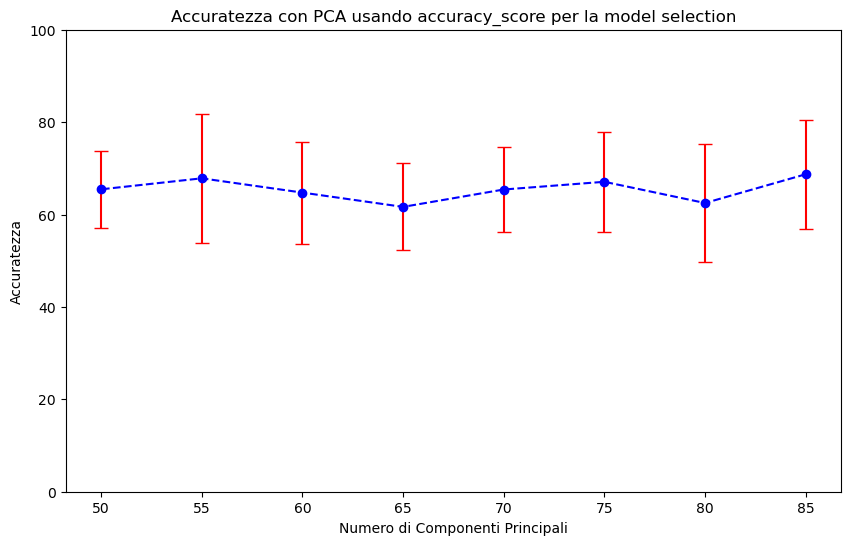

In [28]:
plot_error_bar(scores_df, 0, 7, 'PCA', 'accuracy_score')

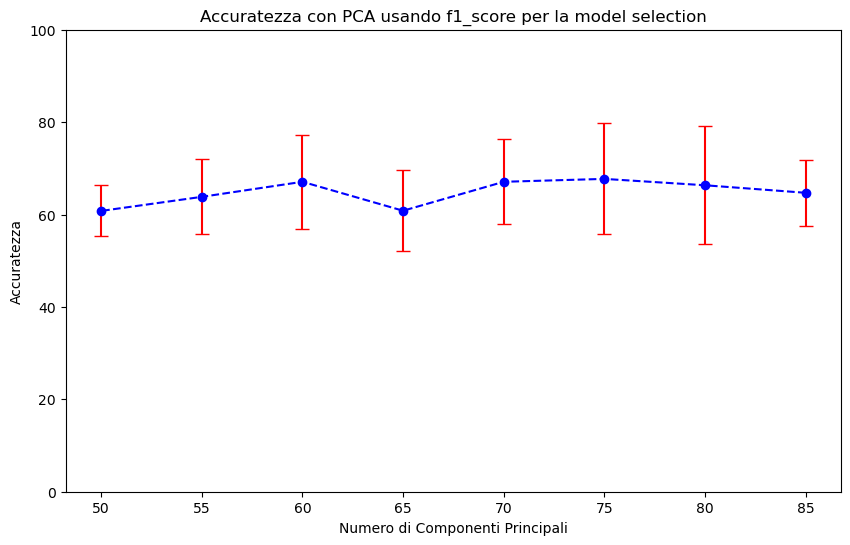

In [29]:
plot_error_bar(scores_df, 8, 15, 'PCA', 'f1_score')

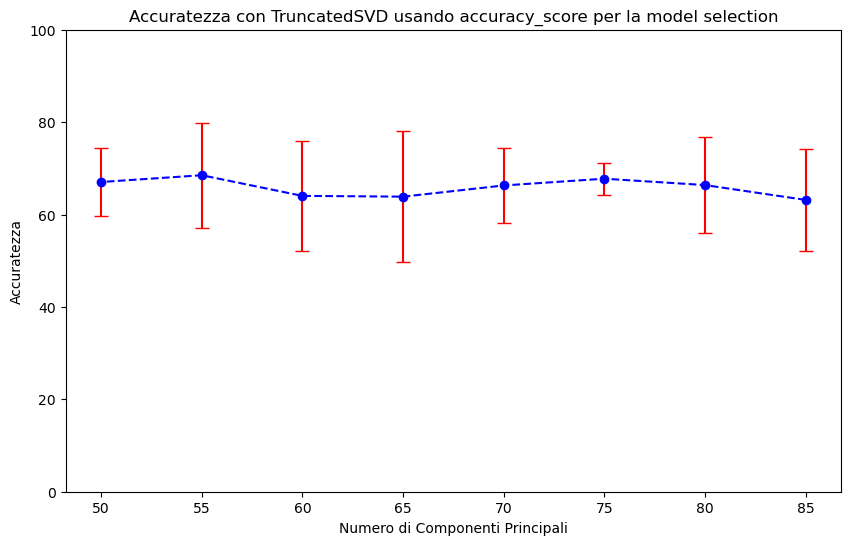

In [30]:
plot_error_bar(scores_df, 16, 23, 'TruncatedSVD', 'accuracy_score')

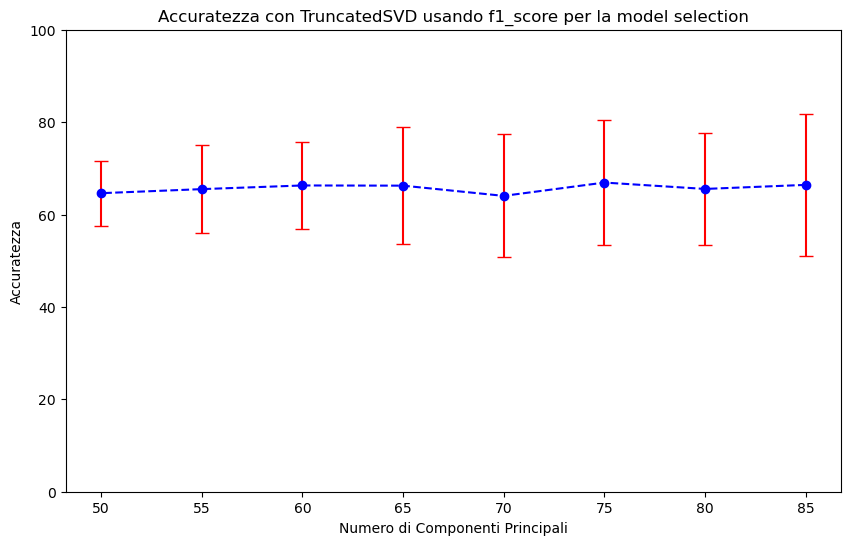

In [32]:
plot_error_bar(scores_df, 24, 31, 'TruncatedSVD', 'f1_score')

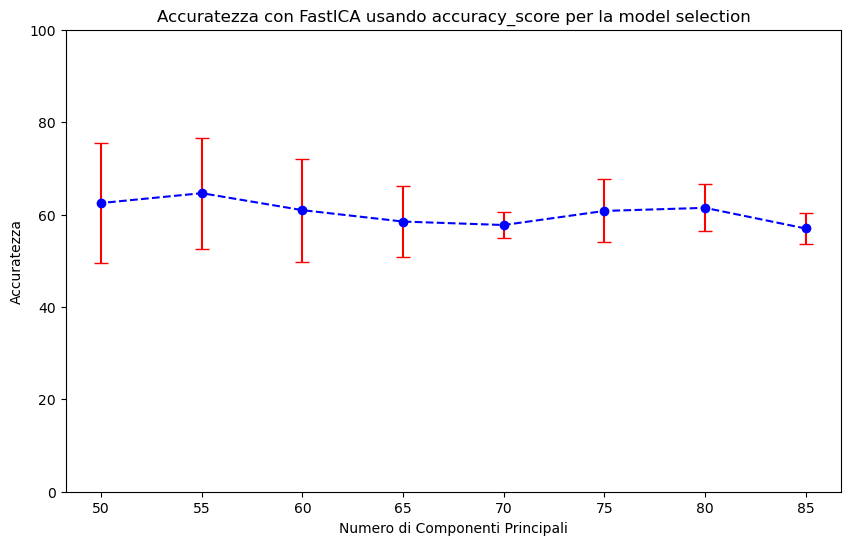

In [34]:
plot_error_bar(scores_df, 32, 39, 'FastICA', 'accuracy_score')

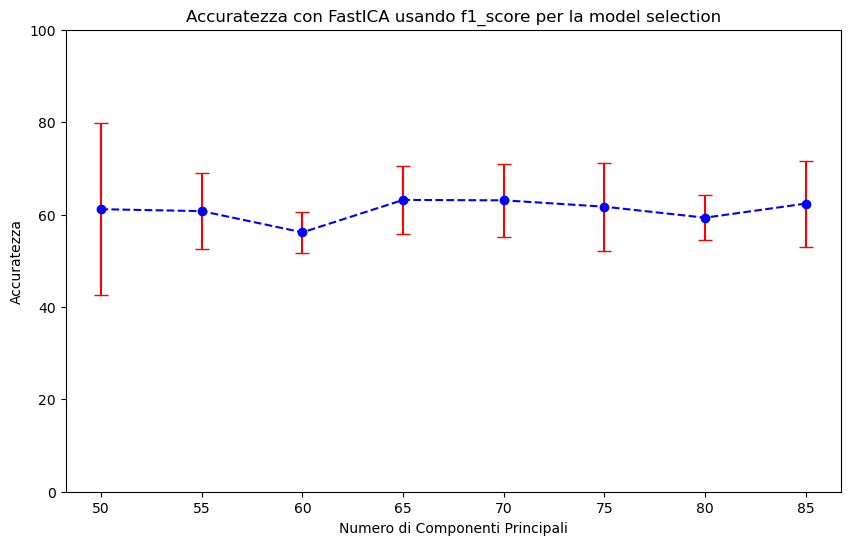

In [37]:
plot_error_bar(scores_df, 40, 47, 'FastICA', 'f1_score')